**Import CIFAR-10 dataset**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
def create_CIFAR_data():

    '''
    A function to load the CIFAR-10 dataset from PyTorch

    Inputs: None

    Returns
        trainset: The CIFAR-10 training data
        trainloader: The data loader containing batches of data from the CIFAR-10 training data
        testset: The CIFAR-10 test data
        testloader: The data loader containing batches of data from the CIFAR-10 test data
    '''

    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    return trainset, trainloader, testset, testloader

**Process CIFAR-10 dataset**

In [3]:
def get_binary_label(targets, index):
    ''' A function to convert the CIFAR-10 target labels
        from values from 0-10 to values in {0,1}.

        Inputs:
          targets: The CIFAR-10 data labels
          index: The index of the positive class

        Returns:
          labels: A new tensor of data labels with each value being 0 or 1
    '''

    zeros = torch.zeros_like(targets)
    ones = torch.ones_like(targets)

    labels = torch.where(targets == index, ones, zeros)

    return labels

In [5]:
import random

def get_branch_indices(targets, classes):

  '''
  A function that determines the indices of input data that will be passed
  to each branch in the ResNet model  with two parallel branches.
  All images of the two classes learning to be classified are passed to both branches,
  images from the other eight classes (called 'background' images) are
  randomly passed to either of the two branches

  Inputs:
    targets: The target labels for the input data
    classes: The two classes of images that are learning to be classified

  Returns:
    Tensors containing the indices of input data to be passed to each branch of the network
  '''

  # Create a list of indices that contain the 'background' images
  # A background image is any images not in either of the two classes being learned
  bg = []
  indices = list(range(len(targets)))
  for index, target in enumerate(targets):
    if target not in classes:
      bg.append(index)

  # Sample half of these indices to be passed to branch one, and the remainder to branch two
  branch_one_bg = random.sample(bg, int(len(bg) / 2))
  branch_two_bg = [x for x in bg if x not in branch_one_bg]

  # Create the list of indices then passed to each branch
  branch_one_idx = [x for x in indices if x not in branch_two_bg]
  branch_two_idx = [x for x in indices if x not in branch_one_bg]

  return torch.tensor(branch_one_idx), torch.tensor(branch_two_idx)

In [7]:
def create_unbalanced_CIFAR10(trainset, class_sizes = [625,625,625,5000,625,5000,625,625,625,625]):

  '''
  A function to alter the CIFAR-10 dataset to have a specified number of instances
  in each class of data.
  
  Inspiration for this solution has been taken from a PyTorch discussion blog discussing oversampling in the CIFAR dataset: 
  https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/6
  (Site accessed on 26th July 2021)

  Inputs:
    trainset: The CIFAR-10 training data
    class_sizes: List of integers that will determine the number of training data items from each class

  Returns:
    trainset: An amended CIFAR-10 training dataset with the specified number of data items in each class
  '''

  labels = np.array(trainset.targets)
  classes, sizes = np.unique(labels, return_counts=True)
  print(sizes)

  imbalanced_indices = []

  # For each class of images sample from the images of that class to give a specified number of images
  for i in range(len(classes)):
    indices = list(np.where(labels == i)[0])
    class_size = class_sizes[i]
    imbalanced_indices.extend(random.sample(indices, class_size))

  trainset.targets = labels[imbalanced_indices]
  trainset.data = trainset.data[imbalanced_indices]
  classes, sizes = np.unique(trainset.targets, return_counts=True)
  print(sizes)

  return trainset

**Creating ResNet model**

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional

In [9]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    '''

    A function to create a 3x3 convolutional layer with padding

    The implementation is taken from the official PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    '''
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    '''
    A function to create a 1x1 convolutional layer

    The implementation is taken from the official PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    ''' 
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [10]:
class BasicBlock(nn.Module):
    '''
    A class to construct the BasicBlock of the ResNet model

    The implementation is taken from the official PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    '''
    
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None, groups: int = 1, base_width: int = 64, dilation: int = 1, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class Bottleneck(nn.Module):
    '''
    A class to construct the Bottleneck of the ResNet model

    The implementation is taken from the PyTorch GitHub repository
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    (site last accessed 13:48 on 6th September 2021)
    '''

    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None, groups: int = 1, base_width: int = 64, dilation: int = 1, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(Bottleneck, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        width = int(planes * (base_width / 64.)) * groups
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [12]:
class ResNetSplitShared(nn.Module):
    '''

    A class to create a version of the ResNet model with two parallel branches that share the early network layers

    Inspiration taken from PyTorch discussion forum:
    https://discuss.pytorch.org/t/how-to-train-the-network-with-multiple-branches/2152
    (website accessed 26th July 2021)
    '''

    def __init__(self, block: Type[Union[BasicBlock, Bottleneck]], layers: List[int], num_classes: int = 10, zero_init_residual: bool = False, groups: int = 1, width_per_group: int = 64, replace_stride_with_dilation: Optional[List[bool]] = None, norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(ResNetSplitShared, self).__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        self.groups = groups
        self.base_width = width_per_group
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        ##### SHARED LAYERS #####
        # Create the layers shared between the two branches
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.layer1 = self._make_shared_layer(block, 64, layers[0])
        self.layer2 = self._make_shared_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        
        ##### BRANCH 1 LAYERS #####
        # Create the layers only found in branch one
        self.branch1_inplanes = 128
        self.branch1layer3 = self._make_branch1_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.branch1layer4 = self._make_branch1_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.branch1fc = nn.Linear(512 * block.expansion, num_classes)


        ##### BRANCH 2 LAYERS #####
        # Create the layers only found in branch two
        self.branch2_inplanes = 128
        self.branch2layer3 = self._make_branch2_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.branch2layer4 = self._make_branch2_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])      
        self.branch2fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_shared_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        '''
        A function to create a shared layer of the network
        '''
        
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        if dilate:
            self.dilation *= stride
            stride = 1
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        
        self.inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)


    def _make_branch1_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        '''
        A function to create a layer of the network for branch one
        '''

        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        if dilate:
            self.dilation *= stride
            stride = 1
        
        if stride != 1 or self.branch1_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.branch1_inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.branch1_inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        
        self.branch1_inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.branch1_inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)


    def _make_branch2_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        '''
        A function to create a layer of the network for branch two
        '''
        
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        
        if dilate:
            self.dilation *= stride
            stride = 1
        
        if stride != 1 or self.branch2_inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.branch2_inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.branch2_inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        
        self.branch2_inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.branch2_inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)


    def get_branch_params(self):

        self.shared_params = [
                        {'params': self.conv1.parameters()},
                        {'params': self.bn1.parameters()},
                         {'params': self.layer1.parameters()},
                         {'params': self.layer2.parameters()},
        ]
        self.branch1_params = [
                        {'params': self.branch1layer3.parameters()},
                        {'params': self.branch1layer4.parameters()},
                         {'params': self.branch1fc.parameters()},
        ]
        self.branch2_params = [
                        {'params': self.branch2layer3.parameters()},
                        {'params': self.branch2layer4.parameters()},
                         {'params': self.branch2fc.parameters()},
        ]

        return self.shared_params, self.branch1_params, self.branch2_params


    def _forward_shared_branch(self, x:Tensor) -> Tensor:
        '''
        A function to perform the forward pass through the shared layers of the network
        '''
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        
        return out


    def _forward_branch_1(self, shared_out: Tensor) -> Tensor:
        '''
        A function to perform the forward pass through the 
        layers of the network found only in branch one
        '''
        branch1_out = self.branch1layer3(shared_out)
        branch1_out = self.branch1layer4(branch1_out)
        branch1_out = self.avgpool(branch1_out)
        branch1_out = torch.flatten(branch1_out, 1)
        branch1_out = self.branch1fc(branch1_out)

        return branch1_out


    def _forward_branch_2(self, shared_out: Tensor) -> Tensor:
        '''
        A function to perform the forward pass through the 
        layers of the network found only in branch two
        '''
        branch2_out = self.branch2layer3(shared_out)
        branch2_out = self.branch2layer4(branch2_out)
        branch2_out = self.avgpool(branch2_out)
        branch2_out = torch.flatten(branch2_out, 1)
        branch2_out = self.branch2fc(branch2_out)

        return branch2_out
    
    
    def forward(self, x: Tensor) -> Tensor:
        '''
        A function to perform the complete forward pass through both branches of the network
        '''
        shared = self._forward_shared_branch(x)
        branch_one_out = self._forward_branch_1(shared)
        branch_two_out = self._forward_branch_2(shared)

        return branch_one_out, branch_two_out


In [13]:
def ResNetSplit18Shared():
    '''
    A function to create the ResNet18 model with two parallel branches
    '''
    return ResNetSplitShared(BasicBlock, [2,2,2,2], num_classes=2)

**Training the ResNet model**


*   Accumulate the gradient * lr
*   Reset the accumulated gradients to zero on a branch if in the previous epoch we had to roll it back



In [18]:
def train_congestion_avoider(trainloader, device, model, optimizer, branch_one_criterion, branch_two_criterion, branch_one_class, branch_two_class, boolean_one, boolean_two, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two):

    '''
    A function to train the branched version of the ResNet model learning to classify two image classes.

    Inputs:
        trainloader: The PyTroch data loader for training data
        device: string - The device the code is being run on
        model: The PyTorch branched ResNet model being trained
        optimizer: The model optimizer
        branch_x_criterion: The criterion used to define the loss function on branch 'x'
        branch_x_class: int - Defines the class that branch 'x' of the model is learning to classify
        boolean_x: boolean - indicator showing if a congestion event occurred on branch 'x'
        branch_x_grads: dict - The accumulated acquired knowledge for on branch 'x' of the network
        epoch_count_x: int - The number of epochs since the last congestion event on branch 'x'

    Returns:
        branch_x_acc: float - accuracy on the training data of branch 'x'
        branch_x_precision: float - precision on the training data of branch 'x'
        branch_x_recall: float - recall on the training data of branch 'x'
        branch_x_F: float - F-score on the training data of branch 'x'
        branch_x_grads: dict - The accumulated acquired knowledge for on branch 'x' of the network
        epoch_count_x: int - The number of epochs since the last congestion event on branch 'x'
     '''

    import copy

    model.train()
    branch_one_train_loss = 0
    branch_two_train_loss = 0
    branch_one_correct = 0
    branch_two_correct = 0
    branch_one_total = 0
    branch_two_total = 0
    branch_one_TP = 0
    branch_one_FP = 0
    branch_one_TN = 0
    branch_one_FN = 0
    branch_two_TP = 0
    branch_two_FP = 0
    branch_two_TN = 0
    branch_two_FN = 0
    branch_two_grads_tmp = {}
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        branch_one_targets = get_binary_label(targets, index=branch_one_class)
        branch_two_targets = get_binary_label(targets, index=branch_two_class)
        
        branch_one_idx, branch_two_idx = get_branch_indices(targets, classes=[branch_one_class, branch_two_class])
        branch_one_inputs = torch.index_select(inputs, 0, branch_one_idx)
        branch_one_targets = torch.index_select(branch_one_targets, 0, branch_one_idx)
        branch_two_inputs = torch.index_select(inputs, 0, branch_two_idx)
        branch_two_targets = torch.index_select(branch_two_targets, 0, branch_two_idx)
        
        branch_one_inputs, branch_two_inputs, branch_one_targets, branch_two_targets = branch_one_inputs.to(device), branch_two_inputs.to(device), branch_one_targets.to(device), branch_two_targets.to(device)
        optimizer.zero_grad()
        
        branch_one_outputs, _ = model(branch_one_inputs)
        _, branch_two_outputs = model(branch_two_inputs)

        branch_one_loss = branch_one_criterion(branch_one_outputs, branch_one_targets)
        branch_two_loss = branch_two_criterion(branch_two_outputs, branch_two_targets)
        
        # Back-propagate the loss from the first branch of the network
        branch_one_loss.backward(retain_graph=True)
        with torch.no_grad():
            # For each parameter update the acquired knowledge
            for name, parameter in model.named_parameters():
                try:
                    # The gradient is temporarily stored so that the difference can be determined on the second backward pass
                    branch_two_grads_tmp[name] = torch.mul(copy.deepcopy(parameter.grad), optimizer.param_groups[0]['lr'])
                    if name not in branch_one_grads.keys():
                        branch_one_grads[name] = torch.mul(copy.deepcopy(parameter.grad), optimizer.param_groups[0]['lr'])
                    else:
                        branch_one_grads[name] += torch.mul(copy.deepcopy(parameter.grad), optimizer.param_groups[0]['lr'])
                except:
                    pass

        # Back-propagate the loss due from branch two
        # Update the branch two acquired knowledge (as gradient multiplied by learning rate)
        # by observing the change in gradient from the results back-propagated from branch one
        branch_two_loss.backward(retain_graph=True)
        with torch.no_grad():
            # For each parameter update the acquired knowledge
            for name, parameter in model.named_parameters():
                if parameter.grad is not None:
                    try:
                        if name not in branch_two_grads.keys():
                            if name in branch_two_grads_tmp.keys():
                                branch_two_grads[name] = (torch.mul(copy.deepcopy(parameter.grad), optimizer.param_groups[0]['lr']) - branch_two_grads_tmp[name])
                            else:
                                branch_two_grads[name] = torch.mul(copy.deepcopy(parameter.grad), optimizer.param_groups[0]['lr'])
                        else:
                            if name in branch_two_grads_tmp.keys():
                                branch_two_grads[name] += (torch.mul(copy.deepcopy(parameter.grad), optimizer.param_groups[0]['lr']) - branch_two_grads_tmp[name])
                            else:
                                branch_two_grads[name] += torch.mul(copy.deepcopy(parameter.grad), optimizer.param_groups[0]['lr'])
                    except:
                        pass
        optimizer.zero_grad()

        # The loss from each branch is summed and back-propagated. The model parameters updated by calling step()
        total_loss = branch_one_loss + branch_two_loss
        total_loss.backward()
        optimizer.step()

        branch_one_train_loss += branch_one_loss.item()
        branch_two_train_loss += branch_two_loss.item()
        _, branch_one_predicted = branch_one_outputs.max(1)
        _, branch_two_predicted = branch_two_outputs.max(1)
        branch_one_total += branch_one_targets.size(0)
        branch_two_total += branch_two_targets.size(0)
        branch_one_correct += branch_one_predicted.eq(branch_one_targets).sum().item()
        branch_two_correct += branch_two_predicted.eq(branch_two_targets).sum().item()

        for target, pred in zip(branch_one_targets, branch_one_predicted):
          if target == 0:
            if pred == 0:
              branch_one_TN += 1
            else:
              branch_one_FP += 1
          elif target == 1:
            if pred == 1:
              branch_one_TP += 1
            else:
              branch_one_FN += 1
        
        for target, pred in zip(branch_two_targets, branch_two_predicted):
          if target == 0:
            if pred == 0:
              branch_two_TN += 1
            else:
              branch_two_FP += 1
          elif target == 1:
            if pred == 1:
              branch_two_TP += 1
            else:
              branch_two_FN += 1

    epoch_count_one += 1
    epoch_count_two += 1

    branch_one_acc = 100.*branch_one_correct/branch_one_total
    if branch_one_TP + branch_one_FP > 0:
      branch_one_precision = 100.*branch_one_TP/(branch_one_TP + branch_one_FP)
    else:
      branch_one_precision = 0
    if branch_one_TP + branch_one_FN > 0:
      branch_one_recall = 100.*branch_one_TP/(branch_one_TP + branch_one_FN)
    else:
      branch_one_recall = 0
    
    branch_two_acc = 100.*branch_two_correct/branch_two_total
    if branch_two_TP + branch_two_FP > 0:
      branch_two_precision = 100.*branch_two_TP/(branch_two_TP + branch_two_FP)
    else:
      branch_two_precision = 0
    if branch_two_TP + branch_two_FN > 0:
      branch_two_recall = 100.*branch_two_TP/(branch_two_TP + branch_two_FN)
    else:
      branch_two_recall = 0

    try:
      branch_one_F = 2 * branch_one_precision * branch_one_recall / (branch_one_precision + branch_one_recall)
    except:
      branch_one_F = 0
    try:
      branch_two_F = 2 * branch_two_precision * branch_two_recall / (branch_two_precision + branch_two_recall)
    except:
      branch_two_F = 0

    print("total train iters ", len(trainloader), '| time: %.3f sec Cat Loss: %.3f | Cat Acc: %.3f%% (%d/%d) | Dog Loss: %.3f | Dog Acc: %.3f%% (%d/%d)'
        % ((time.time()-start_time), branch_one_train_loss/(batch_idx+1), 
           branch_one_acc, branch_one_correct, branch_one_total, 
           branch_two_train_loss/(batch_idx+1), branch_two_acc, 
           branch_two_correct, branch_two_total))
    print('Cat P: : %.3f%% (%d/%d) | Dog P: %.3f%% (%d/%d)'% (branch_one_precision, branch_one_TP, branch_one_TP + branch_one_FP, branch_two_precision, branch_two_TP, branch_two_TP + branch_two_FP))
    print('Cat R: : %.3f%% (%d/%d) | Dog R: %.3f%% (%d/%d)'% (branch_one_recall, branch_one_TP, branch_one_TP + branch_one_FN, branch_two_recall, branch_two_TP, branch_two_TP + branch_two_FN))
    print('Cat F: : %.3f%%         | Dog F: %.3f%%'% (branch_one_F, branch_two_F))

    return branch_one_acc, branch_two_acc, branch_one_precision, branch_two_precision, branch_one_recall, branch_two_recall, branch_one_F, branch_two_F, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two

**Congestion Avoidance scheduler**


*   Based on accumulated gradients (multiplied by the lr in each epoch)
*   As is based on lr*grad is only truly suitable for standard SGD
* Gradients are reset after a congestion on one branch (for that branch only) -- This treats the new position as a new start point to accumulate gradients from



In [19]:
def congestion_avoid(model, optimizer, branch1_metric, branch2_metric, condition, branch_one_grads, branch_two_grads, min_epochs, mult, epoch_count_one, epoch_count_two):

    '''
    A function to determine if a congestion event has occurred.
    When a congestion event occurs the parameters of the model must 
    return a proportion of acquired knowledge. The dictionaries containing
    the acquired knowledge are updated to reflect the 'lost' knowledge.

    Inputs:
        model: The PyTorch ResNet18 model being trained
        branch1_metric: float - The value of the metric returned by branch one in the test function
        branch2_metric: float - The value of the metric returned by branch two in the test function
        condition: float - The congestion condition parameter value
        branch_one_grads: dict - Accumulated acquired knowledgefrom branch one for each model parameter 
        branch_two_grads: dict - Accumulated acquired knowledgefrom branch two for each model parameter 
        min_epochs: int - The minimum number of epochs that must pass between successive congestion events on a model branch
        mult: float - The proportion of acquired knowledge to be returned on congestion
        epoch_count_x: int - The number of epochs since the last congestion event on branch 'x'

    Returns:
        optimizer: 
        model: The ResNet18 model being trained after parameter values have returned knowledge as required
        boolean_one: boolean - Has a congestion event occurred on branch two
        boolean_two: boolean - Has a congestion event occurred on branch one
        branch_one_grads: dict - The accumulated acquired knowledge on branch one after any knowledge has been returned due to congestion
        branch_two_grads: dict - The accumulated acquired knowledge on branch two after any knowledge has been returned due to congestion
        epoch_count_x: int - The number of epochs since the last congestion event on branch 'x'
    '''

    boolean_one = False
    boolean_two = False

    # Determine if a congestion event has occurred on either network branch
    branch1_cond = (branch1_metric < condition * branch2_metric) and (epoch_count_two >= min_epochs)
    branch2_cond = (branch2_metric < condition * branch1_metric) and (epoch_count_one >= min_epochs)

    # On a congestion event return acquired knowledge 
    # and update the dictionary of acquired knowledge
    if branch1_cond:
        boolean_one = True
        print('Branch 1 condition has been met ..... {:.2f}%'.format(100.*condition))
        for name, value in model.named_parameters():
            with torch.no_grad():
                if name in branch_two_grads.keys():
                    value += mult * branch_two_grads[name]
        for name in branch_two_grads.keys():
            branch_two_grads[name] -= mult * branch_two_grads[name]
        epoch_count_two = 0

    elif branch2_cond:
        boolean_two = True
        print('Branch 2 condition has been met ..... {:.2f}%'.format(100.*condition))
        for name, value in model.named_parameters():
            with torch.no_grad():
                if name in branch_one_grads.keys():
                    value += mult * branch_one_grads[name]
        for name in branch_one_grads.keys():
            branch_one_grads[name] -= mult * branch_one_grads[name]
        epoch_count_one = 0
    
    else:
        print('No condition is met ..... {:.2f}%'.format(100.*condition))

    return optimizer, model, boolean_one, boolean_two, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two

**Testing the ResNet model**


*   Congestion condition based on F-Score instead of accuracy
*   Dataset has 1000 cats and 5000 dogs



In [20]:
def linear_cong_condition(min_cond, max_cond, epoch, max_epochs):
    '''
    A function that will linearly interpolate between two values.

    Inputs:
        min_cond: float - The lower bound that is to be interpolated
        max_cond: float - The upper bound that is to be interpolated
        epoch: int - the current epoch of training
        max_epochs: int - The total number of epochs during training

    Returns:
        condition: float - The value linearly interpolated between min_cond & max_cond
    '''

    condition = min_cond + (max_cond - min_cond) * (epoch / max_epochs)

    return condition

In [22]:
def test_congestion_avoider(start_time, testloader, device, model, optimizer, scheduler, branch_one_grads, branch_two_grads, branch_one_class, branch_two_class, branch_one_criterion, branch_two_criterion, epoch, max_epochs, min_cond, max_cond, min_epochs, mult, metric, epoch_count_one, epoch_count_two):
    '''
    Function to test the model. The metrics calculated on the test data are used to determine
    if a congestion event has occurred. The congestion avoidance scheduler is then used to update the
    network parameters and dictionaries of acquired knowledge.
    
    Inputs:
        start_time: time the training procedure began
        testloader: The PyTroch data loader for the test data
        device: The device the code is being run on
        model: The PyTorch ResNet model being trained
        optimizer: The PyTorch optimizer being used for model weight updates (e.g. SGD)
        scheduler: The PyTorch learning rate scheduler being used
        branch_x_grads: dict - The dictionary of acquired knowledge for each parameter in branch 'x' of the network
        branch_x_class: int - Defines the class that branch 'x' of the model is learning to classify
        branch_x_criterion: The criterion used to define the loss function on branch 'x'
        epoch: int - the epoch of the training process
        max_epochs: int - the total number of epochs the model will be trained for
        min_cond: float - the lower bound of the congestion condition parameter that will be interpolated between
        max_cond: float - the upper bound of the congestion condition parameter that will be interpolated between
        min_epochs: int - the minimum number of epochs that must pass between successive congestion events
        mult: float - the multiplicative decrease factor that determines the proportion of knowledge returned
        metric: ['recall','precision','F-score'] - parameter to determine which metric is used to determine a congestion event
        epoch_count_x: int - The number of epochs since the last congestion event on branch 'x'

    Returns:
        optimizer: The PyTorch optimizer being used for model weight updates (e.g. SGD)
        branch_x_val_acc: float - the accuracy of branch 'x' of the model
        branch_x_precision: float - the precision of branch 'x' of the model
        branch_x_recall: float - the recall of branch 'x' of the model
        branch_x_F: float - the F-score of branch 'x' of the model
        boolean_x: boolean - indicator of if a congestion event has occurred
        branch_x_grads: dict - The dictionary of acquired knowledge for each parameter in branch 'x' of the network
        epoch_count_x: int - The number of epochs since the last congestion event on branch 'x'
    '''

    # Create the variables that will be populated as test images are passed through the network
    model.eval()
    branch_one_test_loss = 0
    branch_two_test_loss = 0
    branch_one_correct = 0
    branch_two_correct = 0
    branch_one_total = 0
    branch_two_total = 0
    branch_one_TP = 0
    branch_one_FP = 0
    branch_one_TN = 0
    branch_one_FN = 0
    branch_two_TP = 0
    branch_two_FP = 0
    branch_two_TN = 0
    branch_two_FN = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # Convert the image labels to be in {0,1}
            branch_one_targets = get_binary_label(targets, index=branch_one_class)
            branch_two_targets = get_binary_label(targets, index=branch_two_class)
            inputs, branch_one_targets, branch_two_targets = inputs.to(device), branch_one_targets.to(device), branch_two_targets.to(device)
            # Perform the forward pass through the model
            branch_one_outputs, branch_two_outputs = model(inputs)
            branch_one_loss = branch_one_criterion(branch_one_outputs, branch_one_targets)
            branch_two_loss = branch_two_criterion(branch_two_outputs, branch_two_targets)

            branch_one_test_loss += branch_one_loss.item()
            branch_two_test_loss += branch_two_loss.item()
            _, branch_one_predicted = branch_one_outputs.max(1)
            _, branch_two_predicted = branch_two_outputs.max(1)
            branch_one_total += branch_one_targets.size(0)
            branch_two_total += branch_two_targets.size(0)
            branch_one_correct += branch_one_predicted.eq(branch_one_targets).sum().item()
            branch_two_correct += branch_two_predicted.eq(branch_two_targets).sum().item()

            # Calculate the values for a confusiton matrix for each branch of the network
            for target, pred in zip(branch_one_targets, branch_one_predicted):
              if target == 0:
                if pred == 0:
                  branch_one_TN += 1
                else:
                  branch_one_FP += 1
              elif target == 1:
                if pred == 1:
                  branch_one_TP += 1
                else:
                  branch_one_FN += 1
        
            for target, pred in zip(branch_two_targets, branch_two_predicted):
              if target == 0:
                if pred == 0:
                  branch_two_TN += 1
                else:
                  branch_two_FP += 1
              elif target == 1:
                if pred == 1:
                  branch_two_TP += 1
                else:
                  branch_two_FN += 1

        # Calculate the accuracy, precision, recall and F-score metrics for each branch
        branch_one_val_acc = 100.*branch_one_correct/branch_one_total
        
        if branch_one_TP + branch_one_FP > 0:
          branch_one_precision = 100.*branch_one_TP/(branch_one_TP + branch_one_FP)
        else:
          branch_one_precision = 0
        if branch_one_TP + branch_one_FN > 0:
          branch_one_recall = 100.*branch_one_TP/(branch_one_TP + branch_one_FN)
        else:
          branch_one_recall = 0
        
        branch_two_val_acc = 100.*branch_two_correct/branch_two_total
        
        if branch_two_TP + branch_two_FP > 0:
          branch_two_precision = 100.*branch_two_TP/(branch_two_TP + branch_two_FP)
        else:
          branch_two_precision = 0
        if branch_two_TP + branch_two_FN > 0:
          branch_two_recall = 100.*branch_two_TP/(branch_two_TP + branch_two_FN)
        else:
          branch_two_recall = 0

        try:
          branch_one_F = 2 * branch_one_precision * branch_one_recall / (branch_one_precision + branch_one_recall)
        except:
          branch_one_F = 0
        try:
          branch_two_F = 2 * branch_two_precision * branch_two_recall / (branch_two_precision + branch_two_recall)
        except:
          branch_two_F = 0

        condition = linear_cong_condition(min_cond, max_cond, epoch, max_epochs)

        # Create the variable of the desired metric to pass to the congestion avoidance scheduler
        if metric == 'recall':
            branch_one_metric = branch_one_recall
            branch_two_metric = branch_two_recall
        elif metric == 'precision':
            branch_one_metric = branch_one_precision
            branch_two_metric = branch_two_precision
        elif metric == 'accuracy':
            branch_one_metric = branch_one_val_acc
            branch_two_metric = branch_two_val_acc
        elif metric == 'F-score':
            branch_one_metric = branch_one_F
            branch_two_metric = branch_two_F
        else:
            print('ERROR: Metric must be one of (accuracy, precision, recall, F-score)')

        # Use the congestion avoidance scheulder to return acquire knowledge if required
        optimizer, model, boolean_one, boolean_two, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two = congestion_avoid(model, optimizer, branch_one_metric, branch_two_metric, condition, branch_one_grads, branch_two_grads, min_epochs, mult, epoch_count_one, epoch_count_two)
        scheduler.step()

        print("total test iters ", len(testloader), '| time: %.3f sec Cat Loss: %.3f | Cat Acc: %.3f%% (%d/%d) | Dog Loss: %.3f | Dog Acc: %.3f%% (%d/%d)'
        % ((time.time()-start_time), branch_one_test_loss/(batch_idx+1), 
           100.*branch_one_correct/branch_one_total, branch_one_correct, branch_one_total, 
           branch_two_test_loss/(batch_idx+1), 100.*branch_two_correct/branch_two_total, 
           branch_two_correct, branch_two_total))
        
        print('Cat P: : %.3f%% (%d/%d) | Dog P: %.3f%% (%d/%d)'%(branch_one_precision, branch_one_TP, branch_one_TP + branch_one_FP, branch_two_precision, branch_two_TP, branch_two_TP + branch_two_FP))
        print('Cat R: : %.3f%% (%d/%d) | Dog R: %.3f%% (%d/%d)'%(branch_one_recall, branch_one_TP, branch_one_TP + branch_one_FN, branch_two_recall, branch_two_TP, branch_two_TP + branch_two_FN))
        print('Cat F: : %.3f%%         | Dog R: %.3f%%'%(branch_one_F, branch_two_F))

    # RE-EVALUATE THE MODEL ON THE TEST SET AFTER THE WEIGHTS HAVE BEEN UPDATED ON A CONGESTION EVENT
    # This code is simply for purposes of printing the results to the screen to observe the impact of returning knowledge
    model.eval()
    branch_one_test_loss = 0
    branch_two_test_loss = 0
    branch_one_correct = 0
    branch_two_correct = 0
    branch_one_total = 0
    branch_two_total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            branch_one_targets = get_binary_label(targets, index=branch_one_class)
            branch_two_targets = get_binary_label(targets, index=branch_two_class)
            inputs, branch_one_targets, branch_two_targets = inputs.to(device), branch_one_targets.to(device), branch_two_targets.to(device)
            branch_one_outputs, branch_two_outputs = model(inputs)
            branch_one_loss = branch_one_criterion(branch_one_outputs, branch_one_targets)
            branch_two_loss = branch_two_criterion(branch_two_outputs, branch_two_targets)

            branch_one_test_loss += branch_one_loss.item()
            branch_two_test_loss += branch_two_loss.item()
            _, branch_one_predicted = branch_one_outputs.max(1)
            _, branch_two_predicted = branch_two_outputs.max(1)
            branch_one_total += branch_one_targets.size(0)
            branch_two_total += branch_two_targets.size(0)
            branch_one_correct += branch_one_predicted.eq(branch_one_targets).sum().item()
            branch_two_correct += branch_two_predicted.eq(branch_two_targets).sum().item()

        print("total test iters ", len(testloader), '| time: %.3f sec Cat Loss: %.3f | Cat Acc: %.3f%% (%d/%d) | Dog Loss: %.3f | Dog Acc: %.3f%% (%d/%d)'
        % ((time.time()-start_time), branch_one_test_loss/(batch_idx+1), 
           100.*branch_one_correct/branch_one_total, branch_one_correct, branch_one_total, 
           branch_two_test_loss/(batch_idx+1), 100.*branch_two_correct/branch_two_total, 
           branch_two_correct, branch_two_total))


    return optimizer, branch_one_val_acc, branch_two_val_acc, branch_one_precision, branch_two_precision, branch_one_recall, branch_two_recall, branch_one_F, branch_two_F, boolean_one, boolean_two, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two

**Producing the results of the training process**

*   The standard LR schedule is the Cyclic LR with decaying peaks



In [23]:
import time
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import torch.backends.cudnn as cudnn

In [29]:
def get_cong_avoidance_results(branch_one_class=5, branch_two_class=9, class_sizes_train = [625,625,625,625,625,1000,625,625,625,5000], class_sizes_test = [125,125,125,125,125,1000,125,125,125,1000], epochs=100, min_cond=0.95, max_cond = 0.99, mult_factor=1, lr=0.1, min_epochs = 5, metric='recall'):

    '''
    A function to produce the results of training the branched ResNet model 
    using the congestion avoidance scheduler.

    Inputs:
      branch_x_class: int - The class number of image that branch 'x' is learning to classify
      class_sizes_train: list - Number of training inputs for each class of images
      class_sizes_test: list - Number of test data inputs for each class of images
      epochs: int - the number of epochs the model is trained for
      min_cond: float - the lower bound of the congestion condition parameter that will be interpolated between
      max_cond: float - the upper bound of the congestion condition parameter that will be interpolated between
      mult_factor: float - the multiplicative decrease factor that determines the proportion of knowledge returned
      lr: float - The initial learning rate
      min_epochs: int - the minimum number of epochs that must pass between successive congestion events
      metric: ['recall','precision','F-score'] - parameter to determine which metric is used to determine a congestion event

    Returns:
      branch_x_train_accuracies: list - the accuracy of the model on the training data at each epoch
      branch_x_train_P: list - the precision of the model on the training data at each epoch
      branch_x_train_R: list - the recall of the model on the training data at each epoch
      branch_x_train_F: list - the F-score of the model on the training data at each epoch
      branch_x_test_accuracies: list - the accuracy of the model on the test data at each epoch
      branch_x_test_P: list - the precision of the model on the test data at each epoch
      branch_x_test_R: list - the recall of the model on the test data at each epoch
      branch_x_test_F: list - the F-score of the model on the test data at each epoch
      branch_x_condition: list - indicator to show the epochs at which congestion events occurred on each branch
    '''

    branch_one_grads = {}
    branch_two_grads = {}
    epoch_count_one = 0
    epoch_count_two = 0

    # IMPORT DATA
    trainset, trainloader, testset, testloader = create_CIFAR_data()
    
    # CREATE DATASET WITH CLASS SIZES (NOW CAT DATA IS 10x SMALLER)
    trainset = create_unbalanced_CIFAR10(trainset, class_sizes = class_sizes_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = create_unbalanced_CIFAR10(testset, class_sizes = class_sizes_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

    # CREATE MODEL
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ResNetSplit18Shared()
    model = model.to(device)
    if device == 'cuda':
        print('CUDA device used...')
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    # CREATE LOSS OF EACH BRANCH
    branch_one_samples = [class_sizes_train[branch_two_class] + 5000 / 2, class_sizes_train[branch_one_class]]
    branch_one_weights = torch.tensor([(sum(branch_one_samples) - x)/sum(branch_one_samples) for x in branch_one_samples])
    branch_two_samples = [class_sizes_train[branch_one_class] + 5000 / 2, class_sizes_train[branch_two_class]]
    branch_two_weights = torch.tensor([(sum(branch_two_samples) - x)/sum(branch_two_samples) for x in branch_two_samples])
    branch_one_weights, branch_two_weights = branch_one_weights.to(device), branch_two_weights.to(device)
    
    branch_one_criterion = nn.CrossEntropyLoss(weight=branch_one_weights)
    branch_two_criterion = nn.CrossEntropyLoss(weight=branch_two_weights)
    # CREATE MODEL OPTIMIZER
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=5e-4)
    scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=lr, step_size_up=10, mode="triangular2")

    # BEGIN RECORDING THE TIME
    start_time = time.time()

    branch_one_train_accuracies = []
    branch_two_train_accuracies = []
    branch_one_train_P = []
    branch_two_train_P = []
    branch_one_train_R = []
    branch_two_train_R = []
    branch_one_train_F = []
    branch_two_train_F = []

    branch_one_test_accuracies = []
    branch_two_test_accuracies = []
    branch_one_test_P = []
    branch_two_test_P = []
    branch_one_test_R = []
    branch_two_test_R = []
    branch_one_test_F = []
    branch_two_test_F = []

    branch_one_condition = []
    branch_two_condition = []

    boolean_one = False
    boolean_two = False

    for epoch in range(epochs):
        print('\n********** EPOCH {} **********'.format(epoch + 1))
        print('Learning rate: ', optimizer.param_groups[0]['lr'])
        print('Epoch count: ', epoch_count_one, ', ', epoch_count_two)
        branch_one_train_acc, branch_two_train_acc, b1_train_P, b2_train_P, b1_train_R, b2_train_R, b1_train_F, b2_train_F, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two = train_congestion_avoider(trainloader, device, model, optimizer, branch_one_criterion, branch_two_criterion, branch_one_class, branch_two_class, boolean_one, boolean_two, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two)
        branch_one_train_accuracies.append(branch_one_train_acc)
        branch_two_train_accuracies.append(branch_two_train_acc)
        branch_one_train_P.append(b1_train_P)
        branch_two_train_P.append(b2_train_P)
        branch_one_train_R.append(b1_train_R)
        branch_two_train_R.append(b2_train_R)
        branch_one_train_F.append(b1_train_F)
        branch_two_train_F.append(b2_train_F)
        optimizer, branch_one_val_acc, branch_two_val_acc, b1_test_P, b2_test_P, b1_test_R, b2_test_R, b1_test_F, b2_test_F, boolean_one, boolean_two, branch_one_grads, branch_two_grads, epoch_count_one, epoch_count_two = test_congestion_avoider(start_time, testloader, device, model, optimizer, scheduler, branch_one_grads, branch_two_grads, branch_one_class, branch_two_class, branch_one_criterion, branch_two_criterion, epoch, epochs, min_cond, max_cond, min_epochs, mult_factor, metric, epoch_count_one, epoch_count_two)
        branch_one_test_accuracies.append(branch_one_val_acc)
        branch_two_test_accuracies.append(branch_two_val_acc)
        branch_one_test_P.append(b1_test_P)
        branch_two_test_P.append(b2_test_P)
        branch_one_test_R.append(b1_test_R)
        branch_two_test_R.append(b2_test_R)
        branch_one_test_F.append(b1_test_F)
        branch_two_test_F.append(b2_test_F)

        branch_one_condition.append(boolean_one)
        branch_two_condition.append(boolean_two)

    return branch_one_train_accuracies, branch_two_train_accuracies, branch_one_train_P, branch_two_train_P, branch_one_train_R, branch_two_train_R, branch_one_train_F, branch_two_train_F, branch_one_test_accuracies, branch_two_test_accuracies, branch_one_test_P, branch_two_test_P, branch_one_test_R, branch_two_test_R, branch_one_test_F, branch_two_test_F, branch_one_condition, branch_two_condition

**Function to save results to a pickle file**

In [25]:
import pickle

def save_to_file(fileName, results):

    '''
    A function to save the results of the model training to a pickle file

    Inputs:
        fileName: string - the file that the data will be saved to
        results: list - the list of data items to be saved to the file
    
    Returns:
        A pickle file of the specified name is created and saved
    '''
    
    with open(fileName, 'wb') as file:
        for result in results:
            pickle.dump(result, file)

**Functions to produce the plots of results**

In [49]:
import matplotlib.pyplot as plt

def moving_average(data, smooth_param):

    '''
    A function to calculate the moving average of a list of data

    Inputs:
      data: the raw data that will be smoothed
      smooth_param: int - the number of data items used to create each moving average value

    Returns:
      moving_averages: list - the smoothed data
    '''
    
    index = 0
    moving_averages = []
    
    while index < len(data) - smooth_param + 1:
        sub_data = data[index : index + smooth_param]
        average = sum(sub_data) / smooth_param
        moving_averages.append(average)
        index += 1

    return moving_averages


def plot_results_twoClass(names, params, class_names, colors, smooth = 5):

    '''
    A function to plot the performance metrics of the trained model for each branch of the model on the test data

    Inputs:
      names: list - The list of names of files to be read
      params: list - the list of parameters used in each file, will be used to create a legend
      class_names: list - the list of image classes learned by each model branch
      colors: list - A list of colors used for each line on the plots
      smooth: int - the level of smoothing used in the moving average function to smooth the data

    Returns:
      None
    '''

    # Create a subplot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

    # For each file we must first read the data
    for index, (name, param) in enumerate(zip(names, params)):
        with open(name, 'rb') as data:
            train_acc_one = pickle.load(data)
            train_acc_two = pickle.load(data)
            train_P_one = pickle.load(data)
            train_P_two = pickle.load(data)
            train_R_one = pickle.load(data)
            train_R_two = pickle.load(data)
            train_F_one = pickle.load(data)
            train_F_two = pickle.load(data)
            test_acc_one = pickle.load(data)
            test_acc_two = pickle.load(data)
            test_P_one = pickle.load(data)
            test_P_two = pickle.load(data)
            test_R_one = pickle.load(data)
            test_R_two = pickle.load(data)
            test_F_one = pickle.load(data)
            test_F_two = pickle.load(data)
            congestion_one = pickle.load(data)
            congestion_two = pickle.load(data)

        # Plot the accuracy, precision, recall and F-score in the corresponding subplot
        # Each curve is smoothed to improve the readability of the graph
        ax[0,0].plot(moving_average(test_acc_one,smooth), color = colors[index], label=class_names[0] + ': ' + param)
        ax[0,0].plot(moving_average(test_acc_two,smooth), color = colors[index], linestyle='--', label=class_names[1] + ': ' + param)
        ax[0,0].set_title('Accuracies \n(moving average of over {} epochs)'.format(smooth))
        ax[0,1].plot(moving_average(test_P_one,smooth), colors[index], label=class_names[0] + ': ' + param)
        ax[0,1].plot(moving_average(test_P_two,smooth), colors[index], linestyle='--', label=class_names[1] + ': ' + param)
        ax[0,1].set_title('Precision \n(moving average of over {} epochs)'.format(smooth))
        ax[1,0].plot(moving_average(test_R_one,smooth), colors[index], label=class_names[0] + ': ' + param)
        ax[1,0].plot(moving_average(test_R_two,smooth), colors[index], linestyle='--', label=class_names[1] + ': ' + param)
        ax[1,0].set_title('Recall \n(moving average of over {} epochs)'.format(smooth))
        ax[1,1].plot(moving_average(test_F_one,smooth), colors[index], label=class_names[0] + ': ' + param)
        ax[1,1].plot(moving_average(test_F_two,smooth), colors[index], linestyle='--', label=class_names[1] + ': ' + param)
        ax[1,1].set_title('F-Score \n(moving average of over {} epochs)'.format(smooth))

        # If there are only two files read then vertical lines are added at each epoch where a congestion event occurs
        # Lines are not added if more files are read as the lines would not be interpretable here
        if len(names) == 2:
            for i, val in enumerate(congestion_one):
                if val == 1:
                    ax[0,0].axvline(x=i, color=colors[index], linewidth=0.5)
                    ax[0,1].axvline(x=i, color=colors[index], linewidth=0.5)
                    ax[1,0].axvline(x=i, color=colors[index], linewidth=0.5)
                    ax[1,1].axvline(x=i, color=colors[index], linewidth=0.5)
            for i, val in enumerate(congestion_two):
                if val == 1:
                    ax[0,0].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[0,1].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[1,0].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[1,1].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)

        # Formatting of plots
        fig.text(0.4, 0.04, 'Epoch', ha='center', va='center')
        fig.text(0.06, 0.5, '%', ha='center', va='center', rotation='vertical')
        
        #ax[0,0].set_ylim([60,100])
        #ax[0,1].set_ylim([50,90])
        #ax[1,0].set_ylim([70,100])
        #ax[1,1].set_ylim([60,90])

        handles, labels = ax[0,0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right')
        fig.tight_layout()

    plt.subplots_adjust(left=0.1, right=0.7, top=0.9, bottom=0.1)
    plt.show()


def plot_results_diff_twoClass(names, params, colors, smooth = 5):

    '''
    A function to plot the difference in performance metrics for the trained model using
    the congestion avoidance scheduler with the model without the congestion avoidance scheduler.

    Inputs:
      names: list - The list of names of files to be read
      params: list - the list of parameters used in each file, will be used to create a legend
      class_names: list - the list of image classes learned by each model branch
      colors: list - A list of colors used for each line on the plots
      smooth: int - the level of smoothing used in the moving average function to smooth the data

    Returns:
      None
    '''

    # Create a subplot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

    # For each file read in the data
    for index, (name, param) in enumerate(zip(names, params)):
        with open(name, 'rb') as data:
            train_acc_one = pickle.load(data)
            train_acc_two = pickle.load(data)
            train_P_one = pickle.load(data)
            train_P_two = pickle.load(data)
            train_R_one = pickle.load(data)
            train_R_two = pickle.load(data)
            train_F_one = pickle.load(data)
            train_F_two = pickle.load(data)
            test_acc_one = pickle.load(data)
            test_acc_two = pickle.load(data)
            test_P_one = pickle.load(data)
            test_P_two = pickle.load(data)
            test_R_one = pickle.load(data)
            test_R_two = pickle.load(data)
            test_F_one = pickle.load(data)
            test_F_two = pickle.load(data)
            congestion_one = pickle.load(data)
            congestion_two = pickle.load(data)

        # Calculate the difference in the metrics on the two model branches
        acc_diff = [dog - cat for cat, dog in zip(test_acc_one, test_acc_two)]
        precision_diff = [dog - cat for cat, dog in zip(test_P_one, test_P_two)]
        recall_diff = [dog - cat for cat, dog in zip(test_R_one, test_R_two)]
        fScore_diff = [dog - cat for cat, dog in zip(test_F_one, test_F_two)]

        # Plot the smoothed differences in the repsective subplots
        ax[0,0].plot(moving_average(acc_diff,smooth), color = colors[index], label='{}'.format(param))
        ax[0,0].plot([0]*len(moving_average(acc_diff,smooth)), color='grey', linestyle='--')
        ax[0,0].set_title('Difference in accuracies \n(moving average of over {} epochs)'.format(smooth))

        ax[0,1].plot(moving_average(precision_diff,smooth), colors[index], label='{}'.format(param))
        ax[0,1].plot([0]*len(moving_average(precision_diff,smooth)), color='k', linestyle='--')
        ax[0,1].set_title('Difference in Precision \n(moving average of over {} epochs)'.format(smooth))
        
        ax[1,0].plot(moving_average(recall_diff,smooth), colors[index], label='{}'.format(param))
        ax[1,0].plot([0]*len(moving_average(recall_diff,smooth)), color='grey', linestyle='--')
        ax[1,0].set_title('Difference in Recall \n(moving average of over {} epochs)'.format(smooth))
        
        ax[1,1].plot(moving_average(fScore_diff,smooth), colors[index], label='{}'.format(param))
        ax[1,1].plot([0]*len(moving_average(fScore_diff,smooth)), color='grey', linestyle='--')
        ax[1,1].set_title('Difference in F-Score \n(moving average of over {} epochs)'.format(smooth))
        
        # Add vertical lines at the epochs where a congestion event occurs
        # This is only done if two files are read in otherwise the lines cannot be interpreted
        if len(names) == 2:
            for i, val in enumerate(congestion_one):
                if val == 1:
                    ax[0,0].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[0,1].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[1,0].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[1,1].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
            for i, val in enumerate(congestion_two):
                if val == 1:
                    ax[0,0].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[0,1].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[1,0].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)
                    ax[1,1].axvline(x=i, color=colors[index], linestyle='--', linewidth=0.5)

        # Plot formatting
        fig.text(0.4, 0.04, 'Epoch', ha='center', va='center')
        fig.text(0.06, 0.5, '%', ha='center', va='center', rotation='vertical')

        handles, labels = ax[0,0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right')
        fig.tight_layout()

    #ax[0,0].set_ylim([-5,5])
    #ax[0,1].set_ylim([-10,10])
    #ax[1,1].set_ylim([-2,30])
    #ax[1,0].set_ylim([-5,50])

    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)
    plt.show()


**Baseline results**


*   Baseline result using dogs and trucks
*   Dataset has 1000 images of dogs and 5000 images of trucks



In [30]:
start_time = time.time()
class_sizes_train = [625,625,625,625,625,1000,625,625,625,5000]
class_sizes_test = [125,125,125,125,125,1000,125,125,125,1000]

b1_train_A, b2_train_A, b1_train_P, b2_train_P, b1_train_R, b2_train_R, b1_train_F, b2_train_F, b1_test_A, b2_test_A, b1_test_P, b2_test_P, b1_test_R, b2_test_R, b1_test_F, b2_test_F, b1_condition, b2_condition = get_cong_avoidance_results(branch_one_class=5, branch_two_class=9, class_sizes_train=class_sizes_train, class_sizes_test=class_sizes_test, epochs=100, min_cond=0, max_cond = 0, mult_factor=0, lr=0.1, min_epochs = 0, metric='precision')

Files already downloaded and verified
Files already downloaded and verified
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[ 625  625  625  625  625 1000  625  625  625 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
[ 125  125  125  125  125 1000  125  125  125 1000]
CUDA device used...

********** EPOCH 1 **********
Learning rate:  0.0001
Epoch count:  0 ,  0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


total train iters  86 | time: 37.796 sec Cat Loss: 0.708 | Cat Acc: 55.567% (4711/8478) | Dog Loss: 0.695 | Dog Acc: 59.916% (5106/8522)
Cat P: : 15.644% (630/4027) | Dog P: 69.507% (2822/4060)
Cat R: : 63.000% (630/1000) | Dog R: 56.440% (2822/5000)
Cat F: : 25.065%         | Dog F: 62.296%
No condition is met ..... 0.00%
total test iters  24 | time: 39.953 sec Cat Loss: 0.591 | Cat Acc: 62.633% (1879/3000) | Dog Loss: 0.617 | Dog Acc: 68.100% (2043/3000)
Cat P: : 46.119% (719/1559) | Dog P: 51.532% (723/1403)
Cat R: : 71.900% (719/1000) | Dog R: 72.300% (723/1000)
Cat F: : 56.194%         | Dog R: 60.175%
total test iters  24 | time: 41.034 sec Cat Loss: 0.591 | Cat Acc: 62.633% (1879/3000) | Dog Loss: 0.617 | Dog Acc: 68.100% (2043/3000)

********** EPOCH 2 **********
Learning rate:  0.010090000000000009
Epoch count:  1 ,  1
total train iters  86 | time: 22.428 sec Cat Loss: 0.638 | Cat Acc: 71.562% (6067/8478) | Dog Loss: 0.575 | Dog Acc: 74.020% (6308/8522)
Cat P: : 25.748% (749/2

In [31]:
results = [b1_train_A, b2_train_A, b1_train_P, b2_train_P, b1_train_R, b2_train_R, b1_train_F, b2_train_F, b1_test_A, b2_test_A, b1_test_P, b2_test_P, b1_test_R, b2_test_R, b1_test_F, b2_test_F, b1_condition, b2_condition]
save_to_file('cyclicLR_Baseline_Dogs_Trucks_1000_5000.pickle', results)

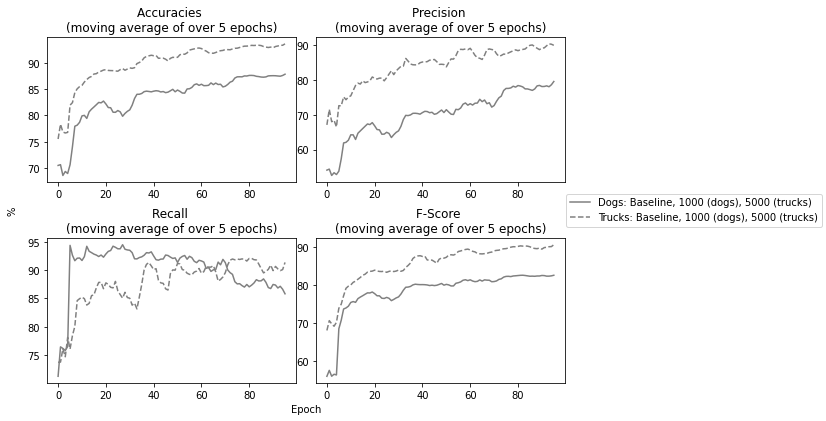

In [51]:
names = ['cyclicLR_Baseline_Dogs_Trucks_1000_5000.pickle']
params = ['Baseline, 1000 (dogs), 5000 (trucks)']
colors = ['grey', 'red', 'blue']
plot_results_twoClass(names, params, class_names=['Dogs', 'Trucks'], colors=colors, smooth = 5)

**Congestion based on precision, congestion condition parameter of 90%, 50% of knowledge returned on congestion, minimum of 5 epochs between events**

In [53]:
b1_train_A, b2_train_A, b1_train_P, b2_train_P, b1_train_R, b2_train_R, b1_train_F, b2_train_F, b1_test_A, b2_test_A, b1_test_P, b2_test_P, b1_test_R, b2_test_R, b1_test_F, b2_test_F, b1_condition, b2_condition = get_cong_avoidance_results(branch_one_class=5, branch_two_class=9, class_sizes_train=class_sizes_train, class_sizes_test=class_sizes_test, epochs=100, min_cond=0.9, max_cond = 0.9, mult_factor=0.5, lr=0.1, min_epochs = 5, metric='precision')

Files already downloaded and verified
Files already downloaded and verified
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[ 625  625  625  625  625 1000  625  625  625 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
[ 125  125  125  125  125 1000  125  125  125 1000]
CUDA device used...

********** EPOCH 1 **********
Learning rate:  0.0001
Epoch count:  0 ,  0
total train iters  86 | time: 21.228 sec Cat Loss: 0.668 | Cat Acc: 60.142% (5097/8475) | Dog Loss: 0.657 | Dog Acc: 63.343% (5400/8525)
Cat P: : 16.317% (576/3530) | Dog P: 70.492% (3225/4575)
Cat R: : 57.600% (576/1000) | Dog R: 64.500% (3225/5000)
Cat F: : 25.430%         | Dog F: 67.363%
No condition is met ..... 90.00%
total test iters  24 | time: 22.945 sec Cat Loss: 0.540 | Cat Acc: 63.767% (1913/3000) | Dog Loss: 0.597 | Dog Acc: 69.833% (2095/3000)
Cat P: : 47.381% (787/1661) | Dog P: 53.749% (681/1267)
Cat R: : 78.700% (787/1000) | Dog R: 68.100% (681/1000)
Cat F: : 59.151%         | Dog R: 60.079%
total

In [54]:
results = [b1_train_A, b2_train_A, b1_train_P, b2_train_P, b1_train_R, b2_train_R, b1_train_F, b2_train_F, b1_test_A, b2_test_A, b1_test_P, b2_test_P, b1_test_R, b2_test_R, b1_test_F, b2_test_F, b1_condition, b2_condition]
save_to_file('cond900_P_mult050_5epochs_1000dog_5000truck.pickle', results)

**Plot the results of this run**

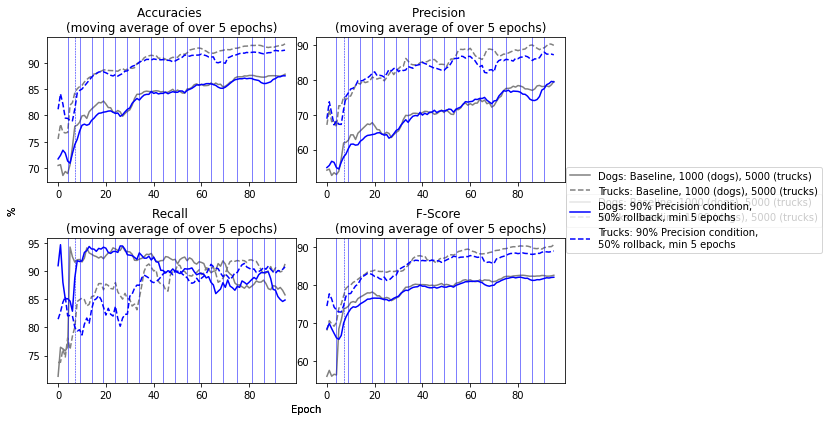

In [57]:
names = ['cyclicLR_Baseline_Dogs_Trucks_1000_5000.pickle', 'cond900_P_mult050_5epochs_1000dog_5000truck.pickle']
params = ['Baseline, 1000 (dogs), 5000 (trucks)', '90% Precision condition, \n50% rollback, min 5 epochs']
colors = ['grey', 'blue']
plot_results_twoClass(names, params, class_names=['Dogs', 'Trucks'], colors=colors, smooth = 5)

In [ ]:
plot_results_diff_twoClass(names, params, colors, smooth = 5)

**Congestion based on precision, congestion condition parameter of 80%, 50% of knowledge returned on congestion, minimum of 5 epochs between events**

In [58]:
start_time = time.time()
b1_train_A, b2_train_A, b1_train_P, b2_train_P, b1_train_R, b2_train_R, b1_train_F, b2_train_F, b1_test_A, b2_test_A, b1_test_P, b2_test_P, b1_test_R, b2_test_R, b1_test_F, b2_test_F, b1_condition, b2_condition = get_cong_avoidance_results(branch_one_class=5, branch_two_class=9, class_sizes_train=class_sizes_train, class_sizes_test=class_sizes_test, epochs=100, min_cond=0.8, max_cond = 0.8, mult_factor=0.5, lr=0.1, min_epochs = 5, metric='precision')

Files already downloaded and verified
Files already downloaded and verified
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[ 625  625  625  625  625 1000  625  625  625 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
[ 125  125  125  125  125 1000  125  125  125 1000]
CUDA device used...

********** EPOCH 1 **********
Learning rate:  0.0001
Epoch count:  0 ,  0
total train iters  86 | time: 21.040 sec Cat Loss: 0.713 | Cat Acc: 56.506% (4790/8477) | Dog Loss: 0.670 | Dog Acc: 60.835% (5185/8523)
Cat P: : 15.022% (577/3841) | Dog P: 68.168% (3118/4574)
Cat R: : 57.700% (577/1000) | Dog R: 62.360% (3118/5000)
Cat F: : 23.838%         | Dog F: 65.135%
No condition is met ..... 80.00%
total test iters  24 | time: 22.741 sec Cat Loss: 0.626 | Cat Acc: 63.567% (1907/3000) | Dog Loss: 0.557 | Dog Acc: 70.767% (2123/3000)
Cat P: : 46.773% (674/1441) | Dog P: 55.476% (623/1123)
Cat R: : 67.400% (674/1000) | Dog R: 62.300% (623/1000)
Cat F: : 55.223%         | Dog R: 58.691%
total

In [59]:
results = [b1_train_A, b2_train_A, b1_train_P, b2_train_P, b1_train_R, b2_train_R, b1_train_F, b2_train_F, b1_test_A, b2_test_A, b1_test_P, b2_test_P, b1_test_R, b2_test_R, b1_test_F, b2_test_F, b1_condition, b2_condition]
save_to_file('cond800_P_mult050_5epochs_1000dog_5000truck.pickle', results)

**Plot results of this run**

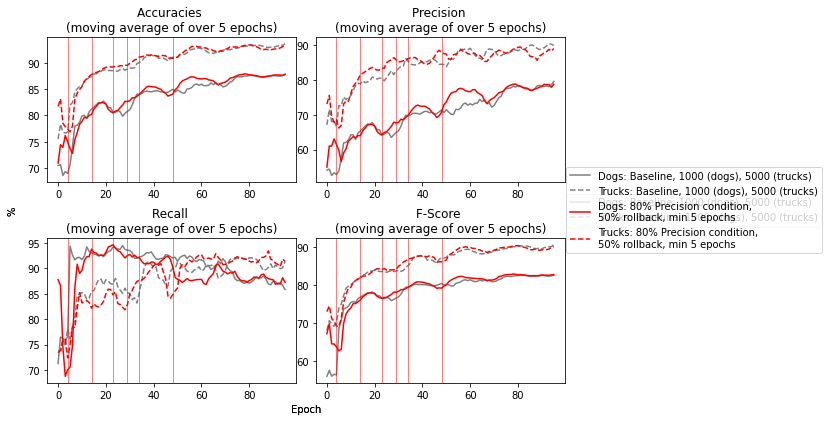

In [61]:
names = ['cyclicLR_Baseline_Dogs_Trucks_1000_5000.pickle', 'cond800_P_mult050_5epochs_1000dog_5000truck.pickle']
params = ['Baseline, 1000 (dogs), 5000 (trucks)', '80% Precision condition, \n50% rollback, min 5 epochs']
colors = ['grey', 'red']
plot_results_twoClass(names, params, class_names=['Dogs', 'Trucks'], colors=colors, smooth = 5)

**Plot results of all runs together**

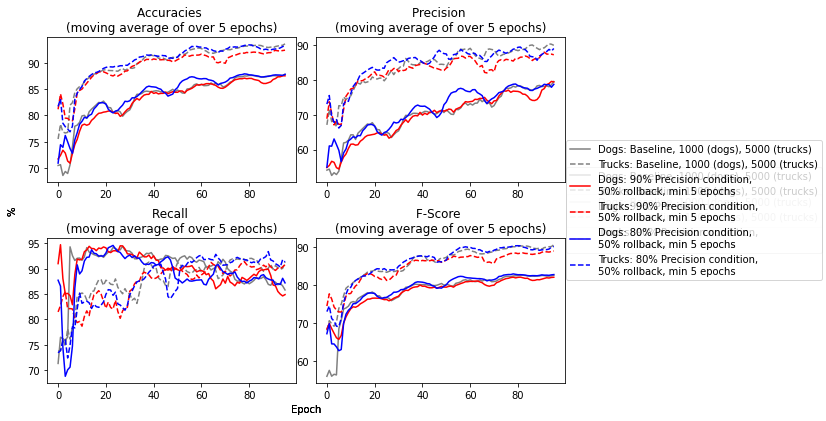

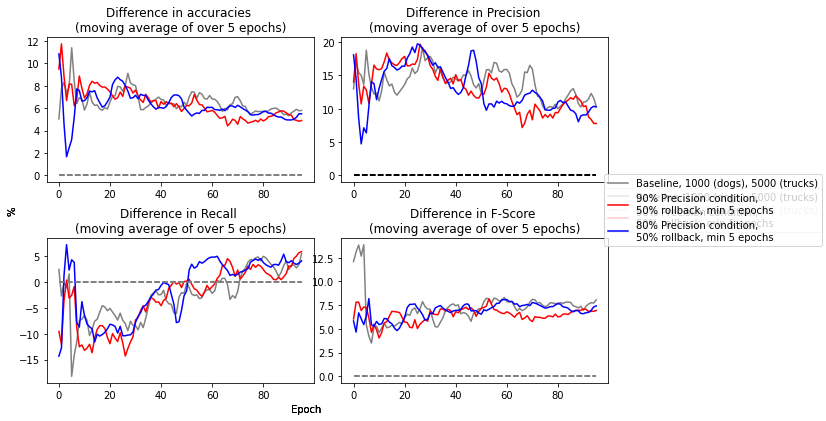

In [63]:
names = ['cyclicLR_Baseline_Dogs_Trucks_1000_5000.pickle', 'cond900_P_mult050_5epochs_1000dog_5000truck.pickle', 'cond800_P_mult050_5epochs_1000dog_5000truck.pickle']
params = ['Baseline, 1000 (dogs), 5000 (trucks)', '90% Precision condition, \n50% rollback, min 5 epochs', '80% Precision condition, \n50% rollback, min 5 epochs']
colors = ['grey', 'red', 'blue']

plot_results_twoClass(names, params, class_names=['Dogs', 'Trucks'], colors=colors, smooth = 5)
plot_results_diff_twoClass(names, params, colors, smooth = 5)